In [23]:
import pandas as pd
from database import select_dataset
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
plt.style.use('ggplot')
import plotly.express as px

In [24]:
# FIND WAY TO WRAP THIS CLEANLY CAUSE IT's A MESS !

aquastat = select_dataset('aquastat').dropna().drop(columns=['Area'])
aquastat = aquastat[~aquastat.ISO.isin(['USA', 'CHN', 'IND', 'RUS'])] # Not parsed !
aquastat = aquastat[~aquastat.Variable.isin(['CI', 'TC', 'ICA', 'AIR'])]
aquastat['Year'] = aquastat['Year'].astype(int)

evapotranspiration = select_dataset('evapotranspiration').dropna().drop_duplicates()
cropcalendar = select_dataset('cropcalendar')#.drop(columns=['Year'])
efficientwater = select_dataset('efficientwater')
wb_data = select_dataset('worldbank')
wb_data['Year'] = wb_data['Year'].astype(int)

crops = select_dataset('sarahcrops').replace('TC', 'CL')

crops = crops[~crops.Variable.isin(['ICA'])]
#cropcalendar = cropcalendar[~cropcalendar.Variable.isin(['ICA'])]

MWU_df = pd.concat([aquastat, evapotranspiration, cropcalendar, efficientwater, wb_data, crops])
MWU_df = MWU_df[~MWU_df.Variable.isin(['CI'])]

In [25]:
MWU_df.to_csv('outputs/MWU_df.csv', index=False)

In [26]:
from graphmodels.graphmodel import GraphModel, converte_to_format, concatenate_graph_specs
import numpy as np
from graphmodels.validation import score_model, plot_diagnostic
from models.Sarah.model_EW import EW_models, MWU_model
from graphmodels.utils import get_X_y_from_data

In [27]:
def get_X_y_from_data(model, data_dict):
    '''TO CLEAN UP'''
    X = {key: data_dict[key] for key in model.inputs_() + model.parameters_()}
    y = {key: data_dict[key] for key in model.variables_() + model.outputs_() if key in data_dict}
    return X, y


def df_to_dict(df):
    X = {}
    for code in df.columns:
        X[code] = df[code].fillna(0)
    return X


def fill_missing_values(df):
    return df.groupby(level='ISO').fillna(method='ffill')\
             .groupby(level='ISO').fillna(method='bfill')


def df_to_data_dict(df, itemized):
    data_dict = {}

    non_item_df = df[~df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year'], columns='Variable', values='Value')
    non_item_df = fill_missing_values(non_item_df)
    item_df = df[df.Variable.isin(itemized)].pivot(
        index=['ISO', 'Year', 'Item'], columns='Variable', values='Value')

    data_dict.update(df_to_dict(non_item_df))
    data_dict.update(df_to_dict(item_df))

    return data_dict


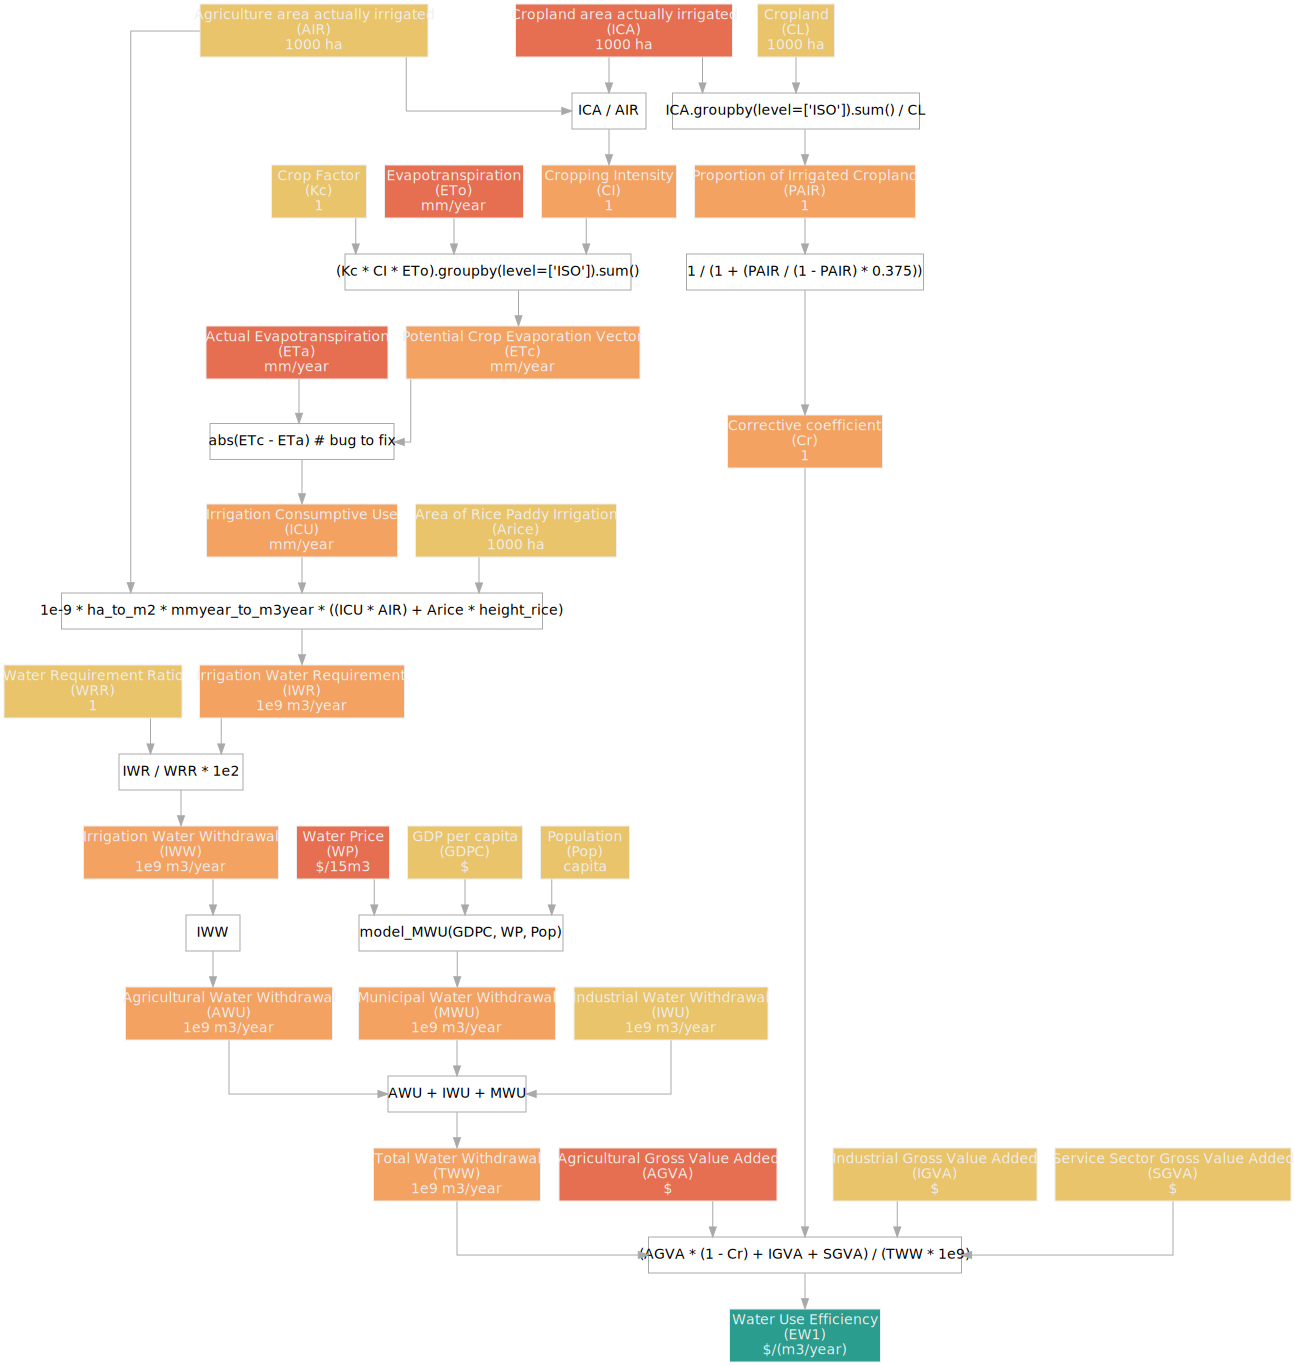

In [45]:
from graphmodels.graphmodel import GraphModel, concatenate_graph_specs
import numpy as np

# Conversions
height_rice = 0.2  # meter height of rice
ha_to_m2 = 1e4  # * 1e3
mm_to_m = 1  # 1e-3 TO CHECK
mmyear_to_m3year = 1  # from mm/year to m3/year as 1mm = 10m3/ha \n",

IWW_nodes = {'Kc': {'type': 'parameter', 'unit': '1', 'name': 'Crop Factor'},
             'ICA': {'type': 'input', 'unit': '1000 ha', 'name': 'Cropland area actually irrigated'},
             'CI': {'type': 'variable',
                    'unit': '1',
                    'name': 'Cropping Intensity',
                    'computation': lambda ICA, AIR, **kwargs: ICA / AIR
                    },
             'ETo': {'type': 'input', 'unit': 'mm/year', 'name': 'Evapotranspiration'},
             'ETc': {'type': 'variable',
                     'name': 'Potential Crop Evaporation Vector',
                     'unit': 'mm/year',
                     'computation': lambda Kc, CI, ETo, **kwargs: (Kc * CI * ETo).groupby(level=['ISO']).sum()
                     },
             'ETa': {'type': 'input',
                     'unit': 'mm/year',
                     'name': 'Actual Evapotranspiration'},
             'ICU': {'type': 'variable',
                     'name': 'Irrigation Consumptive Use',
                     'unit': 'mm/year',
                     'computation': lambda ETc, ETa, **kwargs: abs(ETc - ETa) # bug to fix
                     },
             'AIR': {'type': 'parameter',
                     'unit': '1000 ha',
                     'name': 'Agriculture area actually irrigated'},
             'Arice': {'type': 'parameter',
                       'unit': '1000 ha',
                       'name': 'Area of Rice Paddy Irrigation'},
             'WRR': {'type': 'parameter', 'name': 'Water Requirement Ratio', 'unit': '1'},
             'IWR': {'type': 'variable',
                     'name': ' Irrigation Water Requirement',
                     'unit': '1e9 m3/year',
                     'computation': lambda ICU, AIR, Arice, **kwargs: 1e-9 * ha_to_m2 * mmyear_to_m3year * ((ICU * AIR) + Arice * height_rice)
                     },
             'IWW': {'type': 'variable',
                     'name': ' Irrigation Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda IWR, WRR, **kwargs: IWR / WRR * 1e2
                     },
             'AWU': {'type': 'variable', 'unit': '1e9 m3/year',
                     'name': 'Agricultural Water Withdrawal',
                     'computation': lambda IWW, **kwargs: IWW
                     },
             }


def model_MWU(GDPC, WP, Pop):
    '''Find alternative to hard coding,
    also find way to link the regression data to those coefficient to improve reproducability
    '''

    return np.exp(-0.9522 - 0.3174 * np.log(WP) + 0.5918827 * np.log(GDPC) + 0.9859812 * np.log(Pop)) * 1e-9


MWU_nodes = {'WP': {'type': 'input', 'name': 'Water Price', 'unit': '$/15m3'},
             'GDPC': {'type': 'parameter', 'name': 'GDP per capita', 'unit': '$'},
             'Pop': {'type': 'parameter', 'name': 'Population', 'unit': 'capita'},
             'MWU': {'type': 'variable',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda GDPC, WP, Pop, **kwargs: model_MWU(GDPC, WP, Pop)
                     }
             }
EW1_nodes = {'IWU': {'type': 'parameter',
                     'name': 'Industrial Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'ICA': {'type': 'input',
                     'unit': '1000 ha',
                     'name': 'Cropland area actually irrigated'},
             'MWU': {'type': 'input',
                     'name': 'Municipal Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'AWU': {'type': 'input',
                     'name': 'Agricultural Water Withdrawal',
                     'unit': '1e9 m3/year'},
             'TWW': {'type': 'variable',
                     'name': 'Total Water Withdrawal',
                     'unit': '1e9 m3/year',
                     'computation': lambda AWU, IWU, MWU, **kwargs: AWU + IWU + MWU
                     },
             'AGVA': {'type': 'input',
                      'name': 'Agricultural Gross Value Added',
                      'unit': '$',
                      },

             'CL': {'type': 'parameter',
                    'unit': '1000 ha',
                    'name': 'Cropland'},
             'PAIR': {'type': 'variable',
                      'name': 'Proportion of Irrigated Cropland',
                      'unit': '1',
                      'computation': lambda ICA, CL, **kwargs: ICA.groupby(level=['ISO']).sum() / CL
                      },
             'Cr': {'type': 'variable',
                    'name': 'Corrective coefficient',
                    'unit': '1',
                    'computation': lambda PAIR, **kwargs: 1 / (1 + (PAIR / (1 - PAIR) * 0.375))
                    },

             'IGVA': {'type': 'parameter',
                      'name': 'Industrial Gross Value Added',
                      'unit': '$'},

             'SGVA': {'type': 'parameter',
                      'name': 'Service Sector Gross Value Added',
                      'unit': '$'},
             'EW1': {'type': 'output',
                     'name': 'Water Use Efficiency',
                     'unit': '$/(m3/year)',
                     'computation': lambda TWW, AGVA, IGVA, SGVA, Cr, **kwargs: (AGVA * (1 - Cr) + IGVA + SGVA) / (TWW * 1e9)
                     },
             }

EW2_nodes = {
    'IRWR': {'type': 'input',
                     'name': 'Internal Renewable Water Resources',
                     'unit': 'm3/year'},
    'ERWR': {'type': 'input',
             'unit': 'm3/year',
             'name': 'External Renewable Water Resources'},
    'TRF': {'type': 'variable',
            'name': 'Total Renewable Freshwater',
            'unit': 'm3/year',
            'computation': lambda IRWR, ERWR, **kwargs: IRWR + ERWR
            },
    'DW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Desalination Water'},
    'TW': {'type': 'parameter', 'unit': 'm3/year', 'name': 'Treated Wastewater'},
    'TNCW': {'type': 'variable',
             'name': 'Total Non Conventional Water',
             'unit': 'm3/year',
             'computation': lambda DW, TW, **kwargs: DW + TW
             },
    'TFA': {'type': 'variable',
            'name': 'Total Freshwater Available',
            'unit': 'm3/year',
            'computation': lambda TRF, TNCW, **kwargs: TRF + TNCW
            },
    'TWW': {'type': 'input', 'unit': '1e9 m3/year', 'name': 'Total Water Withdrawal'},
    'EFR': {'type': 'parameter',
            'unit': 'm3/year',
            'name': 'Environmental Flow Requirement'},
    'EW2': {'type': 'output',
            'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
            'unit': '%',
            'computation': lambda TWW, TFA, EFR, **kwargs: TWW / (TFA - EFR) * 1e2
            },
    'Natural EW2': {'type': 'output',
                    'name': 'Share of Freshwater Withdrawal to Freshwater Availability',
                    'unit': '%',
                    'computation': lambda TWW, TRF, EFR, **kwargs: TWW / (TRF - EFR) * 1e2
                    }
}

EW1_model = GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes]))
EW_model =  GraphModel(concatenate_graph_specs([IWW_nodes, MWU_nodes, EW1_nodes, EW2_nodes]))
EW1_model.draw()

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log

IWR
IWW
AWU
MWU
TWW
EW1
          r2  correlation         rmse Variable
0 -10.445159     0.379583  1303.048518      IWR
1  -6.513977     0.239130  1170.067186      IWW
2   0.198792     0.899548   337.729863      AWU
3   0.813218     0.904427     1.011215      MWU
4   0.407680     0.888131   351.954988      TWW
5   0.560649     0.764069  1385.235967      EW1


<AxesSubplot:xlabel='Year', ylabel='EW1'>

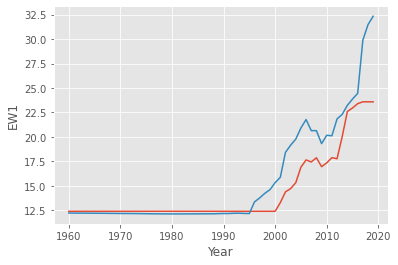

In [48]:
data_dict = df_to_data_dict(MWU_df, itemized=['Kc', 'ICA'])

X, y = get_X_y_from_data(EW1_model, data_dict)
res = EW1_model.run(X)
print(score_model(EW1_model, X, y))

sns.lineplot(data=y['EW1'].loc['HUN'])
sns.lineplot(data=res['EW1'].loc['HUN'])


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log

IWR
IWW
AWU
MWU
TWW
TFA
EW1
EW2
          r2  correlation          rmse Variable
0 -10.445159     0.379583   1303.048518      IWR
1  -6.513977     0.239130   1170.067186      IWW
2   0.198792     0.899548    337.729863      AWU
3   0.813218     0.904427      1.011215      MWU
4   0.407680     0.888131    351.954988      TWW
5   0.989367     0.995188   4090.506776      TFA
6   0.560649     0.764069   1385.235967      EW1
7  -0.856685     0.564226  45473.106584      EW2


<AxesSubplot:xlabel='Year', ylabel='EW2'>

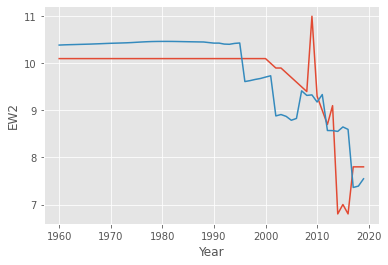

In [52]:
data_dict = df_to_data_dict(MWU_df, itemized=['Kc', 'ICA'])

X, y = get_X_y_from_data(EW_model, data_dict)
res = EW_model.run(X)
print(score_model(EW_model, X, y))

sns.lineplot(data=y['EW2'].loc['HUN'])
sns.lineplot(data=res['EW2'].loc['HUN'])


In [53]:
plot_diagnostic(EW1_model, X, y, 'IWR', hover_data=['ISO', 'Year'])

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



In [31]:
#from graphmodels.utils import df_to_data_dict

df = MWU_df#.query("ISO == 'HUN'")
data_dict = df_to_data_dict(df, ['ICA', 'Kc'])
X, y = get_X_y_from_data(EW1_model, data_dict)
res = EW1_model.run(X)


/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



In [54]:
def expand_series_non_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(1990, 2051)], names=['ISO', 'Year'])
    return df.reindex(multi_index, method='ffill')

def expand_series_itemized(df):
    multi_index = pd.MultiIndex.from_product([df.index.get_level_values('ISO').unique(), np.arange(1990, 2051), df.index.get_level_values('Item').unique()], names=['ISO', 'Year', 'Item'])
    return df.reindex(multi_index)

In [55]:
data_dict_expanded = {}

for key, item in data_dict.items():
    if key not in ['Kc', 'ICA']:
        data_dict_expanded[key] = expand_series_non_itemized(item)

data_dict_expanded['Kc'] = data_dict['Kc']
data_dict_expanded['ICA'] = data_dict['Kc']

In [56]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

def apply_scenario_WP(WP, rate):
    WP = WP.copy()
    for i in range(2020, 2051):
        WP.loc[:, i] = (WP.loc[:, 2019] * rate ** (i - 2019)).values
    return WP


def apply_projection_GVA(GVA):
    GVA = GVA.copy()
    for ISO in GVA.index.get_level_values('ISO').unique():
        fit = Holt(GVA.loc[ISO, 2000:2020].values).fit(smoothing_level=0.3)
        GVA.loc[ISO, 2020:2050] = fit.forecast(31)
       
    return GVA


def apply_projection_AIR(AIR, rate=1.05):
    AIR = AIR.copy()
    for i in range(2020, 2051):
        AIR.loc[:, i] = (AIR.loc[:, 2019] * rate ** (i - 2019)).values
    return AIR

def apply_scenario_WRR(WR, rate=0.9):
    WR = WR.copy()
    for i in range(2020, 2051):
        WR.loc[:, i] = (WR.loc[:, 2019] * rate ** (i - 2019)).values
    return WR

In [57]:
#AGVA_proj = apply_projection_GVA(data_dict_expanded['AGVA'])
#IGVA_proj = apply_projection_GVA(data_dict_expanded['IGVA'])
#SGVA_proj = apply_projection_GVA(data_dict_expanded['SGVA'])
# plt.plot(IGVA_proj.loc['FRA'])bb

In [58]:
data_dict_expanded['IGVA'] = apply_projection_GVA(data_dict_expanded['IGVA'])
data_dict_expanded['AGVA'] = apply_projection_GVA(data_dict_expanded['AGVA'])
data_dict_expanded['SGVA'] = apply_projection_GVA(data_dict_expanded['SGVA'])
data_dict_expanded['GDPC'] = apply_projection_GVA(data_dict_expanded['GDPC'])

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.

/home/simon/anaconda3/lib/python3.7/site

In [59]:
for key, item in data_dict_expanded.items():
    item.to_csv(f'outputs/projection_data/{key}.csv')

In [60]:
data_dict_expanded['AIR'] = apply_projection_AIR(data_dict_expanded['AIR'], rate=1.01)
data_dict_expanded['CL'] = apply_projection_AIR(data_dict_expanded['CL'], rate=1.01)

In [64]:
X, y = get_X_y_from_data(EW_model, data_dict_expanded)
res_1 = EW_model.run(X)


#data_dict_expanded['WRR'] = data_dict_expanded['WRR'] * 100
#data_dict_expanded['WP'] = data_dict_expanded['WP'] * 100
data_dict_expanded_1 = data_dict_expanded.copy()
data_dict_expanded_1['WP'] = apply_scenario_WP(data_dict_expanded_1['WP'], rate=1.1)
data_dict_expanded_1['WRR'] = apply_scenario_WRR(data_dict_expanded_1['WRR'], rate=1)

X, y = get_X_y_from_data(EW_model, data_dict_expanded_1)
res_2 = EW_model.run(X)


data_dict_expanded_2 = data_dict_expanded.copy()
data_dict_expanded_2['WP'] = apply_scenario_WP(data_dict_expanded_1['WP'], rate=1.05)
data_dict_expanded_2['WRR'] = apply_scenario_WRR(data_dict_expanded_1['WRR'], rate=0.999)
X, y = get_X_y_from_data(EW_model, data_dict_expanded_2)
res_3 = EW_model.run(X)

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

divide by zero encountered in log

/home/simon/anaconda3/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning:

invalid value encountered in log



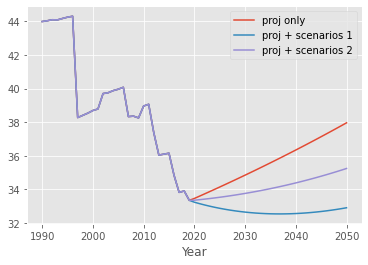

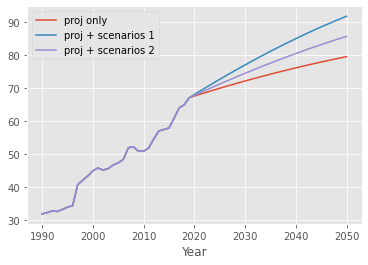

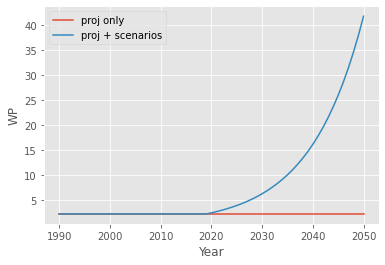

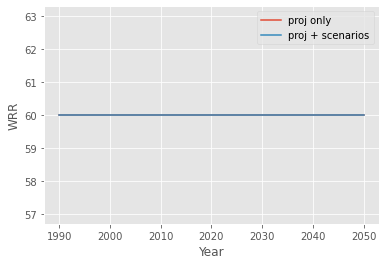

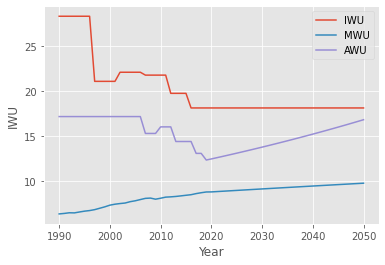

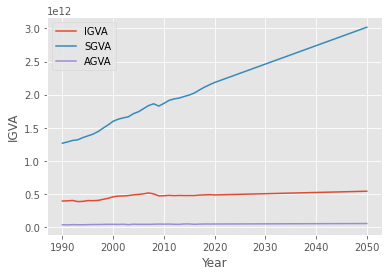

In [67]:
ISO = 'FRA'
sns.lineplot(data=res_1['EW2'].loc[ISO], label='proj only')
sns.lineplot(data=res_2['EW2'].loc[ISO], label='proj + scenarios 1')
sns.lineplot(data=res_3['EW2'].loc[ISO], label='proj + scenarios 2')

plt.show()
sns.lineplot(data=res_1['EW1'].loc[ISO], label='proj only')
sns.lineplot(data=res_2['EW1'].loc[ISO], label='proj + scenarios 1')
sns.lineplot(data=res_3['EW1'].loc[ISO], label='proj + scenarios 2')

plt.show()
sns.lineplot(data=res_1['WP'].loc[ISO], label='proj only')
sns.lineplot(data=res_2['WP'].loc[ISO], label='proj + scenarios')
plt.show()
sns.lineplot(data=res_1['WRR'].loc[ISO], label='proj only')
sns.lineplot(data=res_2['WRR'].loc[ISO], label='proj + scenarios')
plt.show()
sns.lineplot(data=res_1['IWU'].loc[ISO], label='IWU')
sns.lineplot(data=res_1['MWU'].loc[ISO], label='MWU')
sns.lineplot(data=res_1['AWU'].loc[ISO], label='AWU')
plt.show()
sns.lineplot(data=res_1['IGVA'].loc[ISO], label='IGVA')
sns.lineplot(data=res_1['SGVA'].loc[ISO], label='SGVA')
sns.lineplot(data=res_1['AGVA'].loc[ISO], label='AGVA')
plt.show()


In [18]:
WU_df = pd.concat([data_dict['IWU'], data_dict['MWU'], data_dict['AWU'], data_dict['GDPC']], axis=1)

<AxesSubplot:xlabel='GDPC', ylabel='AWU'>

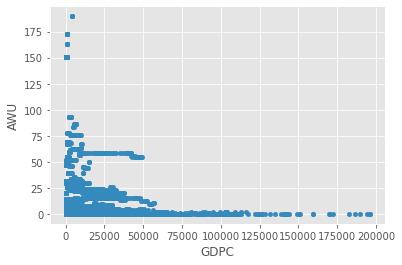

In [19]:
WU_df.plot(x='GDPC', y='AWU', kind='scatter')